In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220707_VARprocess_EC_50subjects_10.0s_segment_3600.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010062_EC     6
sub-010036_EC     5
sub-010019_EC     7
sub-010032_EC     5
sub-010059_EC     6
sub-010012_EC     8
sub-010002_EC     8
sub-010005_EC     6
sub-010047_EC     6
sub-010039_EC     4
sub-010163_EC     6
sub-010063_EC     6
sub-010091_EC     6
sub-010070_EC     6
sub-010073_EC     6
sub-010192_EC     6
sub-010165_EC     6
sub-010141_EC     6
sub-010176_EC     6
sub-010134_EC     5
sub-010196_EC     6
sub-010197_EC     6
sub-010204_EC     6
sub-010207_EC     6
sub-010210_EC     6
sub-010218_EC     6
sub-010228_EC     6
sub-010222_EC     5
sub-010236_EC     5
sub-010238_EC     6
sub-010243_EC     6
sub-010244_EC     6
sub-010258_EC     6
sub-010246_EC     8
sub-010257_EC     6
sub-010267_EC     6
sub-010256_EC     6
sub-010264_EC     7
sub-010272_EC     5
sub-010283_EC     4
sub-010290_EC     6
sub-010291_EC     5
sub-010288_EC     5
sub-010295_EC    10
sub-010307_EC     5
sub-010299_EC     6
sub-010309_EC     6
sub-010306_EC     6
sub-010318_EC    10
sub-010317_EC     6


6.0

6.06

<AxesSubplot:xlabel='order', ylabel='AIC'>

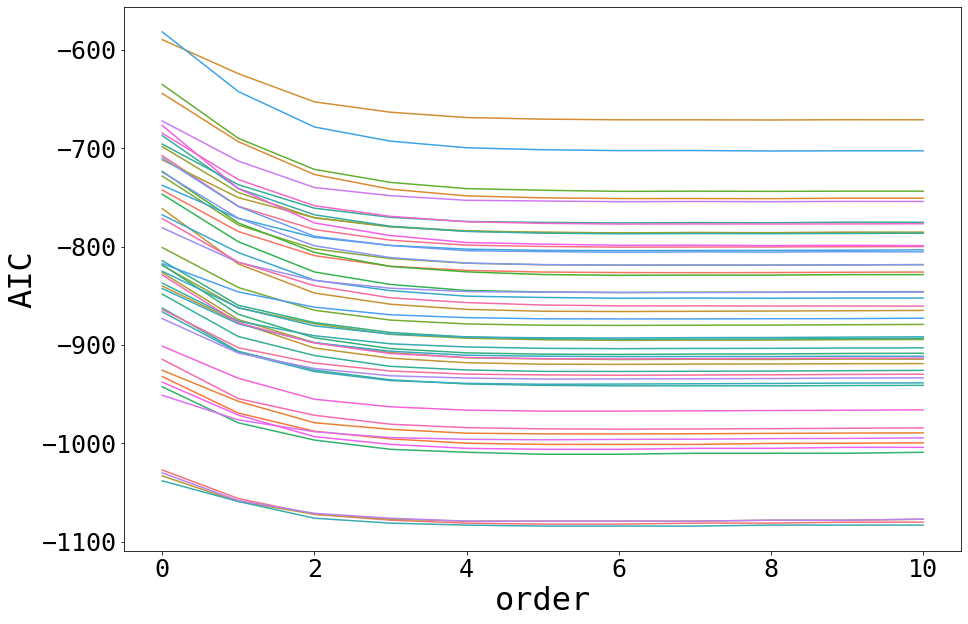

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_33030/1854914166.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_33030/1854914166.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


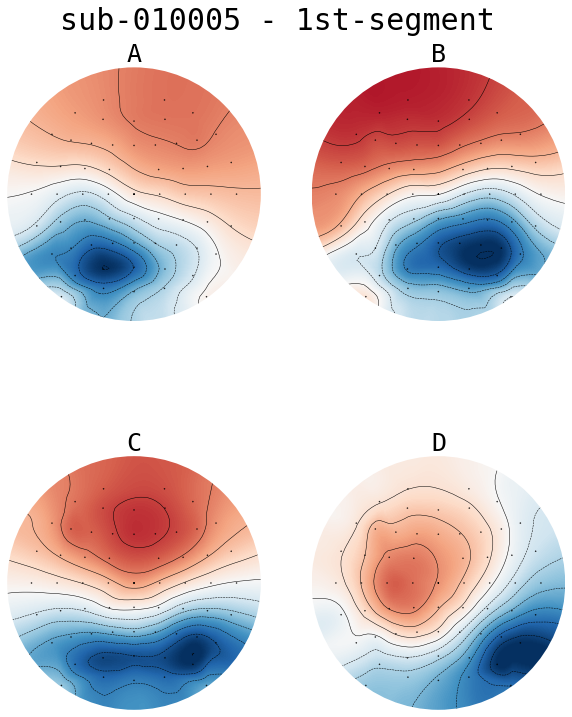

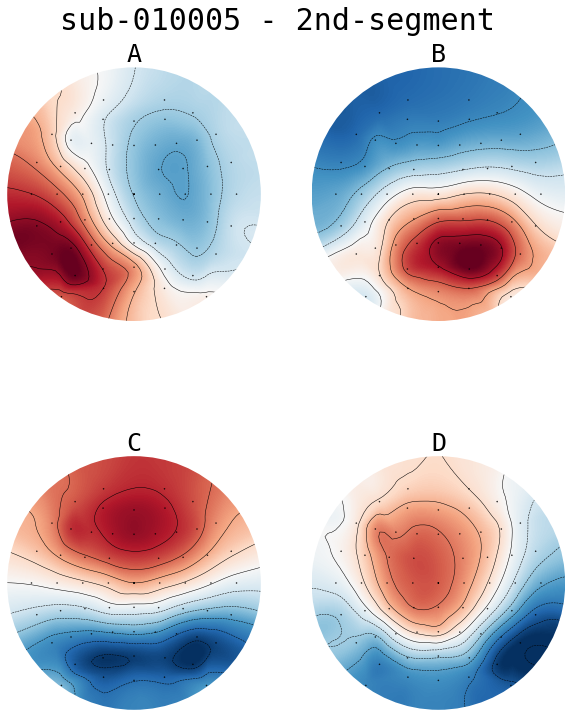

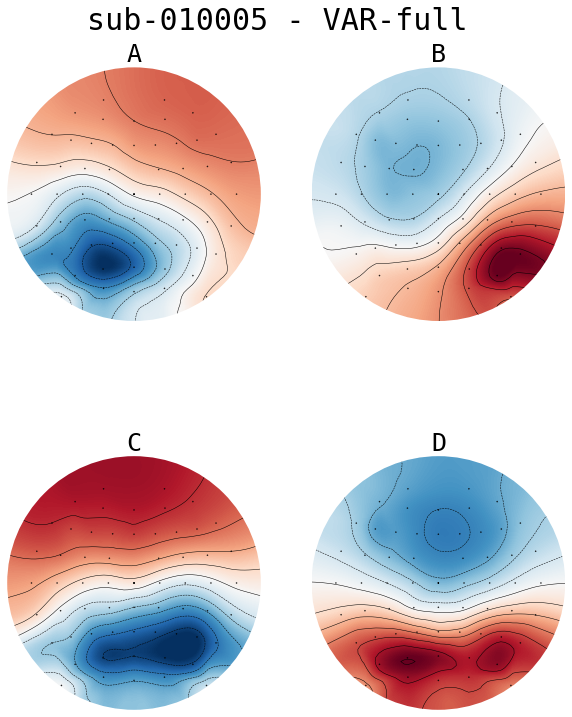

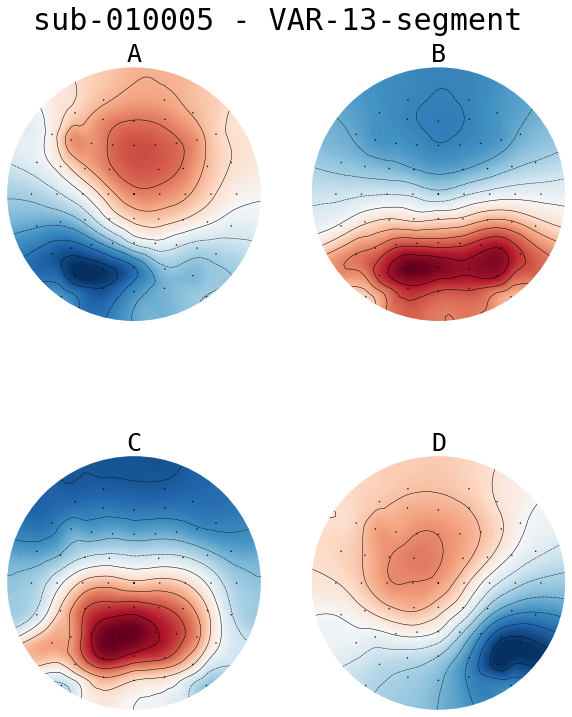

In [5]:
subj_id = "sub-010005"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-13-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

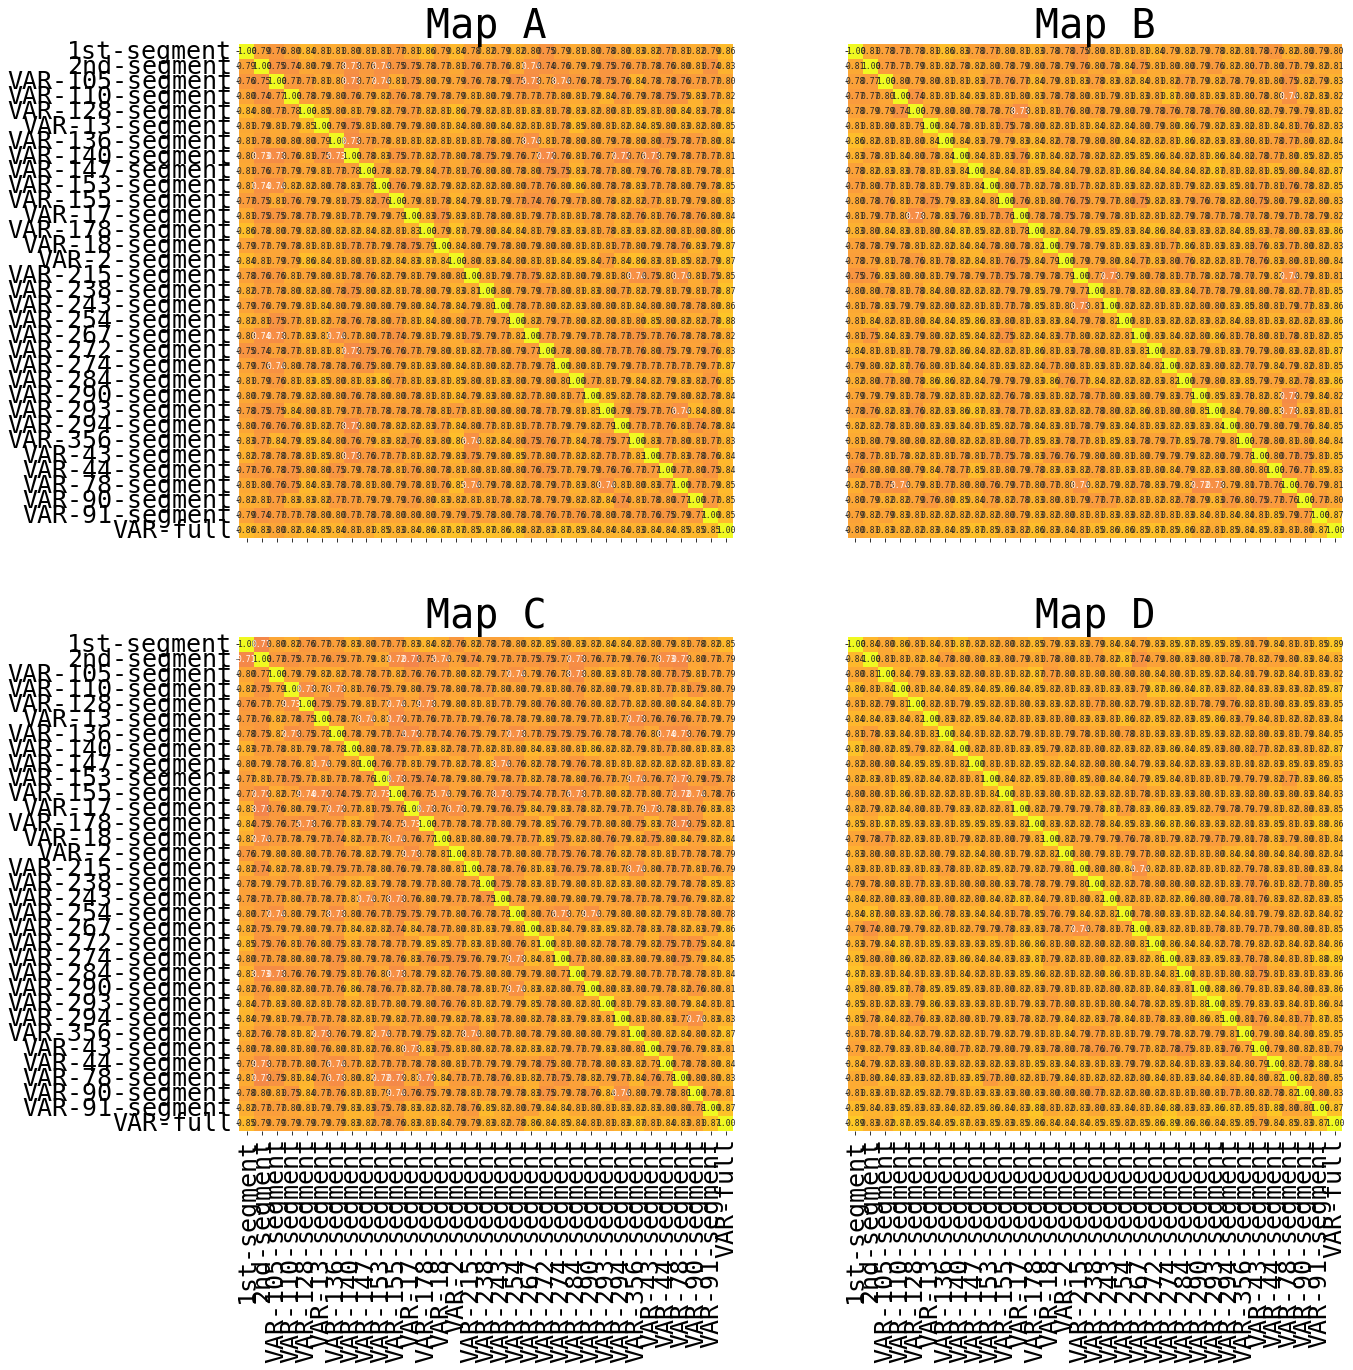

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:39<00:00, 226.77it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

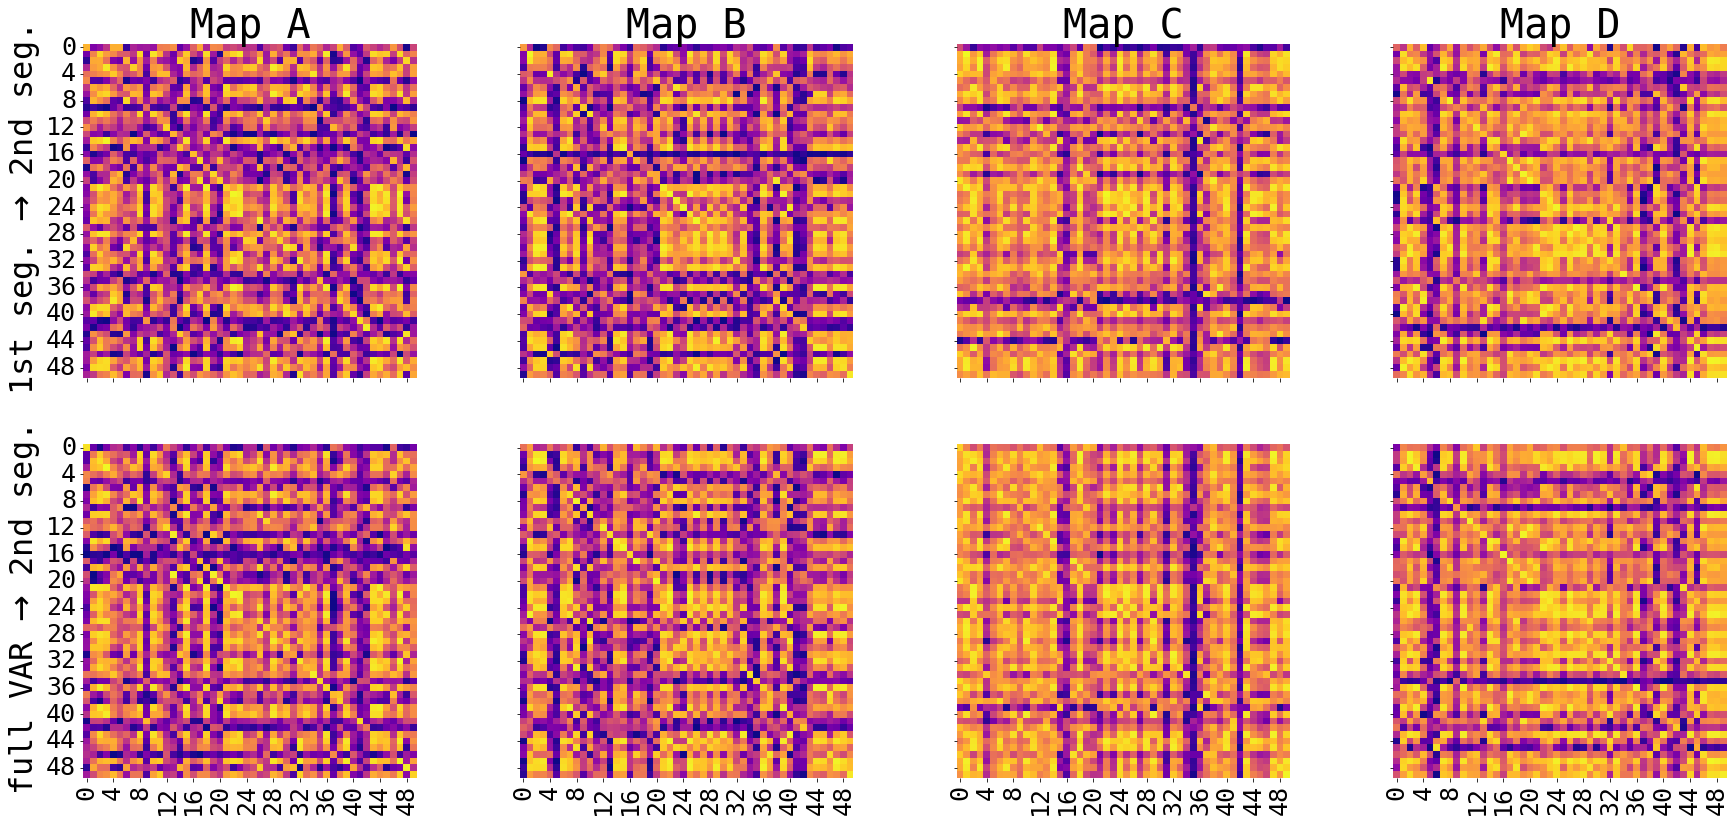

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

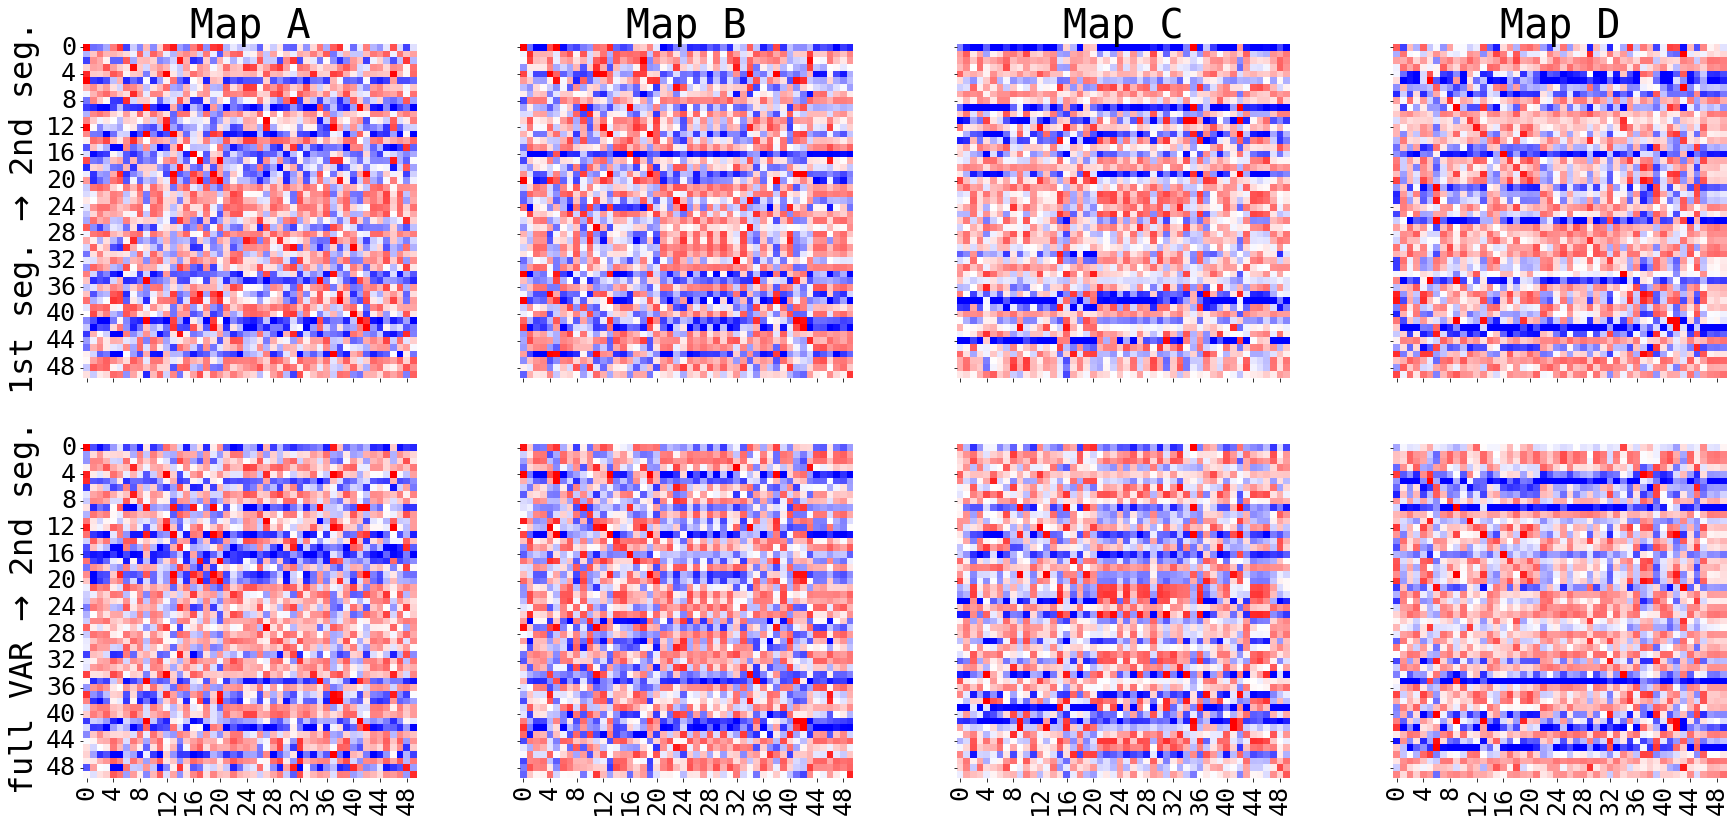

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,14,20,8,20
VAR-full,16,19,11,19


,A,B,C,D
1st-segment,14,20,8,20
VAR-full,16,19,11,19


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.685730   0.613464       0.981922   
                             B           0.685730   0.613464       0.657537   
                             C           0.685730   0.613464       0.761897   
                             D           0.685730   0.613464       0.706863   
           2nd-segment       A           0.662455   0.597467       0.793424   
...                                           ...        ...            ...   
sub-010317 VAR-segments-mean D           0.786255   0.720177       0.863702   
sub-010318 VAR-segments-mean A           0.875193   0.812648       0.794086   
                             B           0.875193   0.812648       0.823131   
                             C           0.875193   0.812648       0.866805   
                             D           0.875193   0.812648       0.922824   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.239904   16.493403  14.545455   
                             B           0.247501   18.392643  13.508197   
                             C           0.245502   15.493802  15.845161   
                             D           0.267093   20.491803  13.014634   
           2nd-segment       A           0.257497   16.893243  15.242604   
...                                           ...         ...        ...   
sub-010317 VAR-segments-mean D           0.252352   12.934826  19.502863   
sub-010318 VAR-segments-mean A           0.213848   16.746635  12.799894   
                             B           0.250686   17.223111  14.546931   
                             C           0.269479   16.173531  16.691460   
                             D           0.265987   16.556711  16.074548   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.725000       0.103333   
                             B                0.071082       0.702746   
                             C                0.066775       0.091205   
                             D                0.119940       0.097451   
           2nd-segment       A                0.737578       0.065217   
...                                                ...            ...   
sub-010317 VAR-segments-mean D                0.070321       0.072302   
sub-010318 VAR-segments-mean A                0.682083       0.164678   
                             B                0.082616       0.720050   
                             C                0.072350       0.068484   
                             D                0.103809       0.062153   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.076667       0.095000  
                             B                0.079160       0.147011  
                             C                0.747557       0.094463  
                             D                0.089955       0.692654  
           2nd-segment       A                0.121118       0.076087  
...                                                ...            ...  
sub-010317 VAR-segments-mean D                0.064038       0.793339  
sub-010318 VAR-segments-mean A                0.073871       0.079368  
                             B                0.107852       0.089482  
                             C                0.758904       0.100261  
                             D                0.085632       0.748406  

[800 rows x 10 columns]

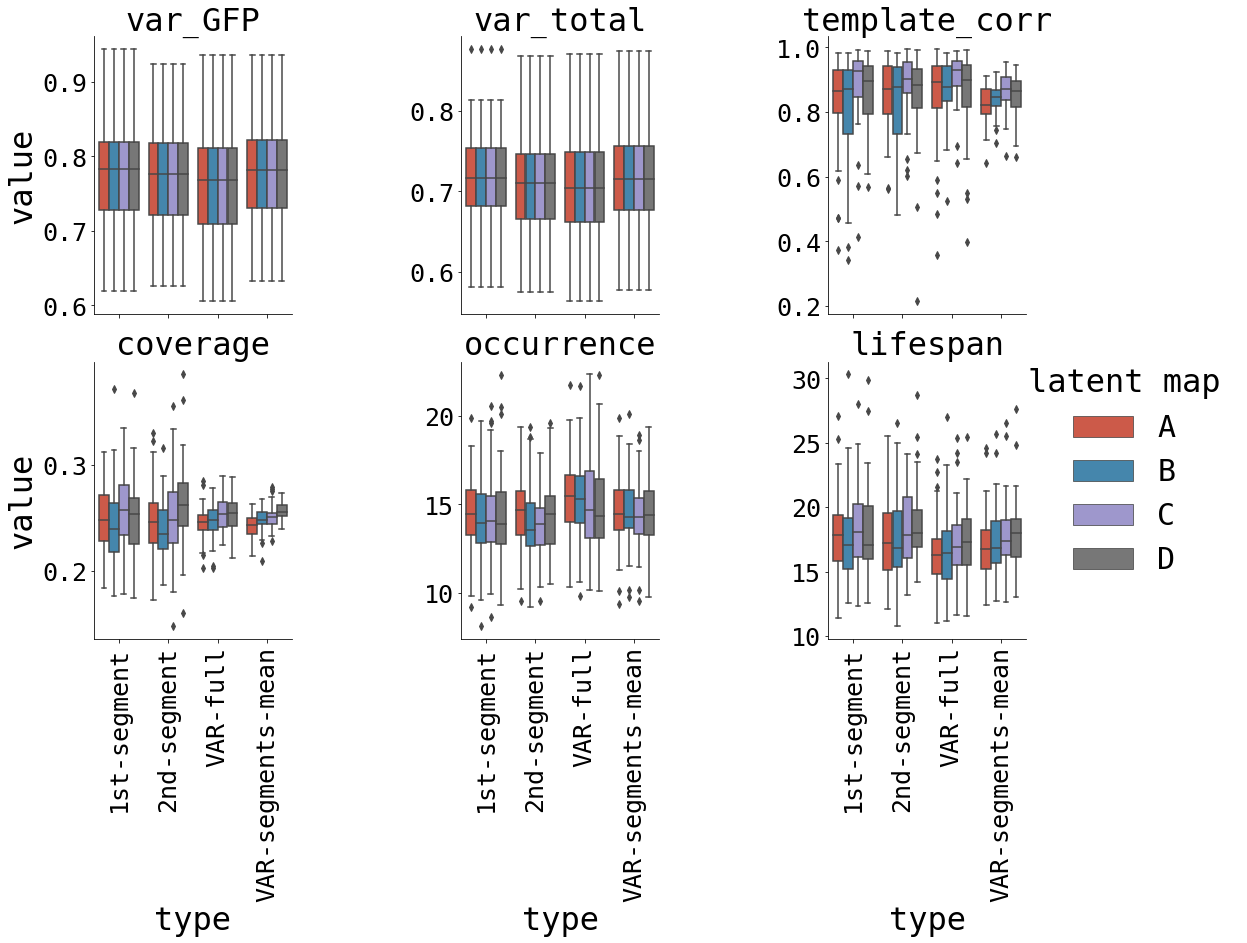

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,81.548537,1.402102e-21,0.046061,0.844958


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,14.875958,49.0,two-sided,8.433366e-20,4.638351e-19,fdr_by,5.774e+16,0.472064
1,diffs,VAR-full,real_data,True,True,9.329707,49.0,two-sided,1.912613e-12,5.259686e-12,fdr_by,4.472e+09,0.434539
2,diffs,VAR-segments,real_data,True,True,-0.703168,49.0,two-sided,4.852790e-01,8.896782e-01,fdr_by,0.194,-0.031136


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,75.318686,1.539302e-20,0.026744,0.733519


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,16.094695,49.0,two-sided,3.385373e-21,1.861955e-20,fdr_by,1.314e+18,0.342053
1,diffs,VAR-full,real_data,True,True,9.047976,49.0,two-sided,5.001321e-12,1.375363e-11,fdr_by,1.777e+09,0.347191
2,diffs,VAR-segments,real_data,True,True,0.371353,49.0,two-sided,7.119752e-01,1.000000e+00,fdr_by,0.164,0.012988


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,7.038997,0.001392,0.033858,0.746155


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-4.933235,49.0,two-sided,0.000010,0.000053,fdr_by,1965.264,-0.465379
1,diffs,VAR-full,real_data,True,True,-2.774950,49.0,two-sided,0.007793,0.021432,fdr_by,4.659,-0.354635
2,diffs,VAR-segments,real_data,True,True,-0.035440,49.0,two-sided,0.971873,1.000000,fdr_by,0.154,-0.004452


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,1.156117,0.31896,0.008593,0.757141


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,0.087931,49.0,two-sided,0.930290,1.000000,fdr_by,0.154,0.010484
1,diffs,VAR-full,real_data,True,True,1.081419,49.0,two-sided,0.284804,0.783212,fdr_by,0.267,0.179397
2,diffs,VAR-segments,real_data,True,True,1.439500,49.0,two-sided,0.156367,0.783212,fdr_by,0.404,0.213728


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,42.483106,5.174921e-14,9.853856e-12,0.105994,0.8048,False,0.757456,0.001272


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-7.151478,49.0,two-sided,3.865917e-09,1.063127e-08,fdr_by,3.1e+06,-0.567766
1,diffs,VAR-full,real_data,True,True,-7.331891,49.0,two-sided,2.033869e-09,1.063127e-08,fdr_by,5.707e+06,-0.768789
2,diffs,VAR-segments,real_data,True,True,-3.037941,49.0,two-sided,3.812404e-03,6.989407e-03,fdr_by,8.688,-0.245313


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,46.852622,5.260320e-15,2.639385e-12,0.08811,0.786558,False,0.728638,0.000502


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,8.205631,49.0,two-sided,9.279072e-11,5.103490e-10,fdr_by,1.084e+08,0.499661
1,diffs,VAR-full,real_data,True,True,7.834398,49.0,two-sided,3.425331e-10,9.419659e-10,fdr_by,3.114e+07,0.719176
2,diffs,VAR-segments,real_data,True,True,3.368303,49.0,two-sided,1.480105e-03,2.713526e-03,fdr_by,20.064,0.250360


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           3.019209  1.998801          2.0   
           2nd-segment           3.173683  1.995768          2.0   
           VAR-full              2.676119  1.999217          2.0   
sub-010005 1st-segment           3.419193  1.995992          2.0   
           2nd-segment           3.778176  1.978685          2.0   
...                                   ...       ...          ...   
sub-010306 VAR-segments-mean     4.192691  1.992338          2.0   
sub-010307 VAR-segments-mean     2.793431  1.988847          2.0   
sub-010309 VAR-segments-mean     3.408447  1.973945          2.0   
sub-010317 VAR-segments-mean     3.875744  1.981955          2.0   
sub-010318 VAR-segments-mean     3.155897  1.981684          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.205451         1.299662     84.000000  
           2nd-segment            1.139023         1.230291     36.000000  
           VAR-full               1.286551         1.329457     84.000000  
sub-010005 1st-segment            1.021349         1.092468     48.000000  
           2nd-segment            0.984831         1.052793     48.000000  
...                                    ...              ...           ...  
sub-010306 VAR-segments-mean      0.925172         0.982946     49.600000  
sub-010307 VAR-segments-mean      1.197903         1.302106     36.000000  
sub-010309 VAR-segments-mean      1.030054         1.121045     48.266667  
sub-010317 VAR-segments-mean      1.006763         1.079705     50.400000  
sub-010318 VAR-segments-mean      1.119749         1.219962     43.600000  

[200 rows x 6 columns]

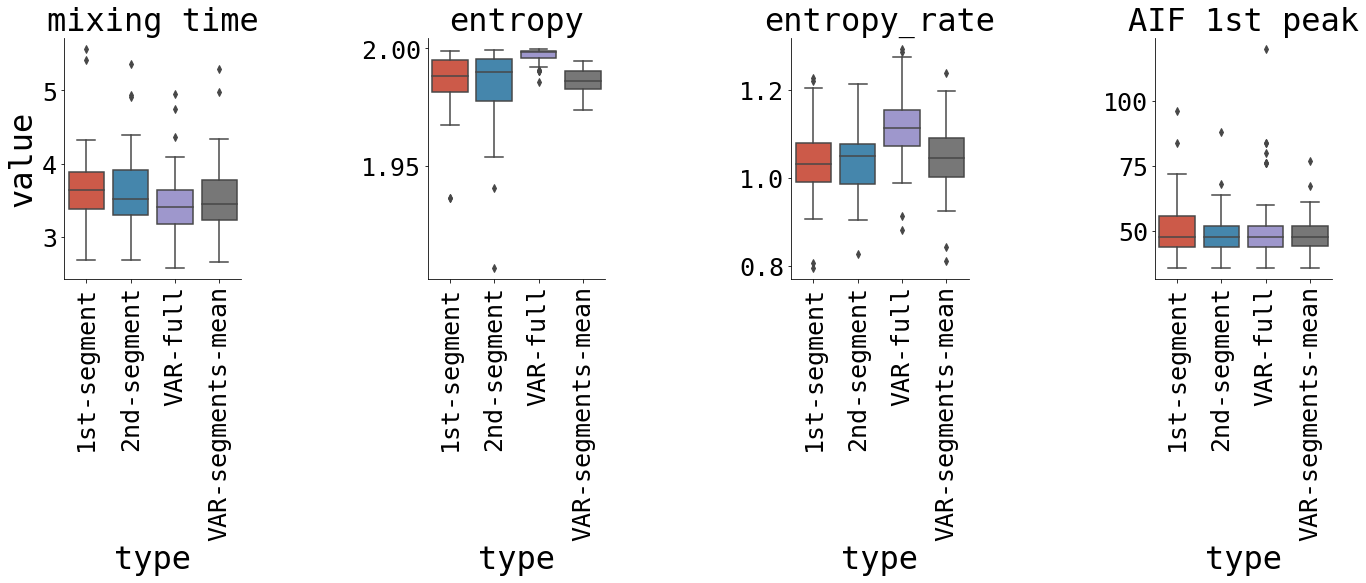

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010002,3.019209,1.998801,2.0,1.205451,1.299662,84.0,1st-segment
0,sub-010002,3.173683,1.995768,2.0,1.139023,1.230291,36.0,2nd-segment
0,sub-010002,2.726584,1.987623,2.0,1.200166,1.304430,60.0,VAR-105-segment
0,sub-010002,2.728144,1.995504,2.0,1.213942,1.312705,48.0,VAR-110-segment
0,sub-010002,2.713337,1.988235,2.0,1.193214,1.289398,64.0,VAR-128-segment
...,...,...,...,...,...,...,...,...
0,sub-010318,3.248020,1.987000,2.0,1.095130,1.196989,44.0,VAR-44-segment
0,sub-010318,3.146171,1.995599,2.0,1.108819,1.201761,40.0,VAR-78-segment
0,sub-010318,3.108845,1.989515,2.0,1.124856,1.207966,44.0,VAR-90-segment
0,sub-010318,2.971710,1.967872,2.0,1.124951,1.227898,44.0,VAR-91-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010002,0.154474,-0.003033,-0.066429,-48.000000,real_data
1,sub-010005,0.358984,-0.017307,-0.036519,0.000000,real_data
2,sub-010012,0.181594,-0.008207,-0.008331,0.000000,real_data
3,sub-010019,0.280155,-0.004487,0.000472,-8.000000,real_data
4,sub-010032,-0.211024,0.000610,0.061006,4.000000,real_data
...,...,...,...,...,...,...
145,sub-010306,0.164222,0.005507,-0.006588,2.400000,VAR-segments
146,sub-010307,0.265880,-0.018022,-0.039641,0.000000,VAR-segments
147,sub-010309,0.733487,0.002270,-0.041963,3.733333,VAR-segments
148,sub-010317,-0.411208,-0.010024,0.060820,1.600000,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,27.921367,2.531076e-10,1.903586e-07,0.077518,0.645073,False,0.449788,4.700938e-09


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,7.942178,49.0,two-sided,2.342037e-10,1.288120e-09,fdr_by,4.476e+07,0.411201
1,diffs,VAR-full,real_data,True,True,6.200056,49.0,two-sided,1.149839e-07,3.162056e-07,fdr_by,1.25e+05,0.679223
2,diffs,VAR-segments,real_data,True,True,2.979222,49.0,two-sided,4.486061e-03,8.224445e-03,fdr_by,7.533,0.302221


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,31.063684,3.558485e-11,0.080346,0.602317


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-15.518189,49.0,two-sided,1.517054e-20,8.343798e-20,fdr_by,3.057e+17,-0.678253
1,diffs,VAR-full,real_data,True,True,-5.918956,49.0,two-sided,3.119215e-07,8.577842e-07,fdr_by,4.885e+04,-0.589661
2,diffs,VAR-segments,real_data,True,True,-0.123349,49.0,two-sided,9.023350e-01,1.000000e+00,fdr_by,0.155,-0.012913


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,446.382883,5.854625e-50,0.426089,0.633982


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-49.238648,49.0,two-sided,2.151296e-43,1.183213e-42,fdr_by,6.29e+39,-1.779726
1,diffs,VAR-full,real_data,True,True,-22.530506,49.0,two-sided,1.649529e-27,4.536206e-27,fdr_by,1.856e+24,-1.840793
2,diffs,VAR-segments,real_data,True,True,-2.430903,49.0,two-sided,1.876641e-02,3.440509e-02,fdr_by,2.198,-0.187966


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,1.883928,0.157455,0.163339,0.00971,0.870144,False,0.850766,0.020675


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.219017,49.0,two-sided,0.031148,0.171313,fdr_by,1.439,-0.254995
1,diffs,VAR-full,real_data,True,True,-0.558156,49.0,two-sided,0.579279,1.000000,fdr_by,0.178,-0.070202
2,diffs,VAR-segments,real_data,True,True,1.336543,49.0,two-sided,0.187545,0.515749,fdr_by,0.355,0.167831
